In [202]:
# final version of the project
import os
import json
import uuid
import base64
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#   Class Invariants:
#   self.tables: a dictionary that contains table names as keys and their corresponding lists of rows as values.
#   all tables in self.tables have a unique name.
#   every row in a table has a unique "id" key.

class NoSQLDatabase:


#   Precondition: 
#   db_name is a string that represents the name of the database.

#   Postcondition: 
#   a NoSQLDatabase object is created, and if the database file with the name db_name exists,  
#   its data is loaded; otherwise, a new database file with that name is created.
    def __init__(self, db_name):
        self.db_name = db_name
        self.db_path = f"{db_name}.json"
        self.tables = {}
        
        print("Database created!")
        if os.path.isfile(self.db_path):
            self.load_data()
        else:
            self.save_data()

            
#   Precondition: 
#   none.

#   Postcondition: 
#   the current data in self.tables is saved in the database file with the name self.db_name.
    def save_data(self):
        with open(self.db_path, "w") as f:
            json.dump(self.tables, f)

            
#   Precondition: 
#   none.

#   Postcondition: 
#   the data from the database file with the name self.db_name is loaded into self.tables.
    def load_data(self):
        with open(self.db_path, "r") as f:
            self.tables = json.load(f)
            

#   Precondition: 
#   filename is a string that represents the name of the file to be saved; 
#   data is a bytes object that represents the content of the file; 
#   mime_type is a string that represents the MIME type of the file.

#   Postcondition: 
#   the file with the given name and content is saved in the "files" table of the database.
    @classmethod
    def save_data_file(self, filename, data):
        file_id = str(uuid.uuid4())
        file_path = f"files/{file_id}"
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, "wb") as f:
            f.write(data)
        
    
#   Precondition: 
#   table_name is a string that represents the name of the table to be created.

#   Postcondition:
#   a new table with the given name is created in self.tables.
    def create_table(self, table_name):
        self.tables[table_name] = []
        self.save_data()

        
#   Precondition: 
#   table_name(str) represents the name of the table to insert data into; 
#   data is a dictionary that represents the row to be inserted into the table.

#   Postcondition: 
#   the row represented by data is inserted into the table with the given name. 
    def insert_row(self, table_name, data):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        table.append(data)
        self.save_data()
        

#   Precondition: 
#   table_name(str) represents the name of the table to select rows from; 
#   filter_fn is an optional function that takes a row dictionary as input and returns a Boolean value 
#   indicating whether the row should be included in the result; 
#   sort_fn is an optional function that takes a row dictionary as input and returns a value 
#   that can be used for sorting.

#   Postcondition: 
#   a list of rows from the table with the given name is returned, 
#   where each row is a dictionary. If filter_fn is not None, only the rows for which 
#   filter_fn(row) is True are included in the result. 
#   If sort_fn is not None, the rows are sorted based on the values returned by sort_fn.
    def select_rows(self, table_name, filter_fn=None, sort_fn=None):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        if filter_fn:
            table = filter(filter_fn, table)

        if sort_fn:
            table = sorted(table, key=sort_fn)

        return list(table)

    
#   Precondition: 
#   table_name(str) represents the name of the table to update rows in; 
#   filter_fn is a function that takes a row dictionary as input and returns a Boolean value 
#   indicating whether the row should be updated; update_fn is a function that takes a row dictionary 
#   as input and updates it in some way.

#   Postcondition: 
#   the rows in the table with the given name for which filter_fn(row) is True are updated 
#   by calling update_fn(row) on them.
    def update_rows(self, table_name, filter_fn, update_fn):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        for row in table:
            if filter_fn(row):
                update_fn(row)

        self.save_data()
        
        
#   Preconditions:
#   table_name is a string representing the name of the table to retrieve.

#   Postconditions:
#   If table_name is not a valid table name in the database, a ValueError is raised with a message indicating that the table does not exist.
#   If table_name is a valid table name in the database, the corresponding table is returned.
    def get_table(self, table_name):

        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        return table

#   Precondition: 
#   table_name is a string that represents the name of the table to delete rows from; 
#   filter_fn is an optional function that takes a row dictionary as input and returns a Boolean value 
#   indicating whether the row should be deleted.

#   Postcondition: 
#   the rows in the table with the given name for which filter_fn(row) is True are deleted.
    def delete_rows(self, table_name, filter_fn=None):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        if filter_fn:
            table = filter(lambda row: not filter_fn(row), table)

        self.tables[table_name] = list(table)
        self.save_data()
      
    
#   Precondition: 
#   table_name (str): the name of the table to get rows from, must exist in the database.
#   condition (dict, optional): the condition to match rows against, if provided, must be a non-empty dictionary.

#   Postcondition: 
#   If condition is not provided, returns all rows from the table as a list.
#   If condition is provided, returns a list of rows that match the condition.
#   If no rows match the condition, returns an empty list.
    def get_row(self, table_name, condition=None):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        if condition is None:
            return table

        result = []
        for row in table:
            match = True
            for key, value in condition.items():
                if row.get(key) != value:
                    match = False
                    break
            if match:
                result.append(row)
        return result

    
#   Preconditions: 
#   table_name (str): the name of the table to clean the row from, must exist in the database.
#   row_id (int): the ID of the row to clean, must exist in the table.

#   Postconditions: 
#   If the row with row_id is found in the table, removes all keys with empty or None values from the row.
#   If the row with row_id is not found in the table, raises a ValueError.
    def clean_row(self, table_name, row_id):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        for row in table:
            if row.get("id") == row_id:
                for key, value in list(row.items()):
                    if value is None or value == "":
                        del row[key]
                self.save_data()
                return

        raise ValueError(f"Row with id '{row_id}' not found in table '{table_name}'.")
        
        
#    Preconditions:
#    db_name (str): the name of the database to plot table data from, must exist.

#    Postconditions:
#    Plots a bar chart of the sizes of all tables in the database.
#    X-axis of the plot shows the names of all tables in the database.
#    Y-axis of the plot shows the number of rows in each table.
#    Displays the plot.
    @classmethod
    def plot_table_data(cls, db_name):
        db = cls(db_name)
        table_names = list(db.tables.keys())
        table_sizes = [len(db.tables[table_name]) for table_name in table_names]

        plt.bar(table_names, table_sizes)
        plt.title(f"{db_name} Table Sizes")
        plt.xlabel("Table Name")
        plt.ylabel("Number of Rows")
        plt.show()
        
        
#   Preconditions:
#   table_name is a string representing the name of an existing table in the database
#   row_id is an integer representing the id of an existing row in the specified table

#   Postconditions:
#   Displays the image from the specified row in the specified table if it exists and has a valid image path. Otherwise, raises an error.
    def display_image(self, table_name, row_id):
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table '{table_name}' does not exist.")

        for row in table:
            if row.get("id") == row_id:
                image_path = row.get("image_path")
                if not image_path:
                    raise ValueError(f"No image path found for row with id '{row_id}' in table '{table_name}'.")
                try:
                    image = Image.open(image_path)
                    plt.imshow(np.array(image))
                    plt.axis('off')
                    plt.show()
                    return
                except:
                    raise ValueError(f"Error opening image at path '{image_path}' for row with id '{row_id}' in table '{table_name}'.")
        
        raise ValueError(f"Row with id '{row_id}' not found in table '{table_name}'.")



Database created!
[{'name': 'Alice', 'age': 22, 'average_grade': 4.5}, {'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]
[{'name': 'Alice', 'age': 22, 'average_grade': 4.5}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]
[{'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}, {'name': 'Alice', 'age': 22, 'average_grade': 4.5}]
[{'name': 'Alice', 'age': 22, 'average_grade': 4.8}, {'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]
Database created!


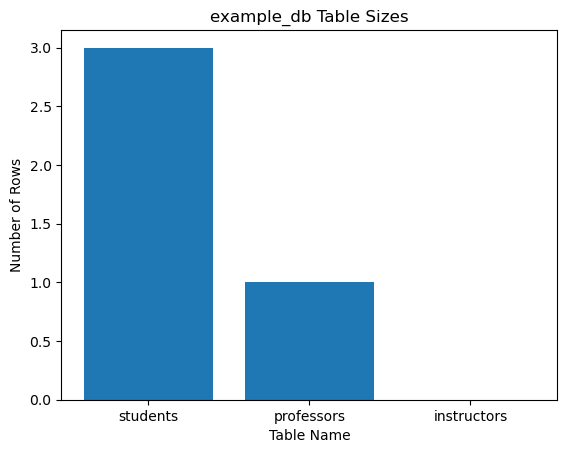

Database created!


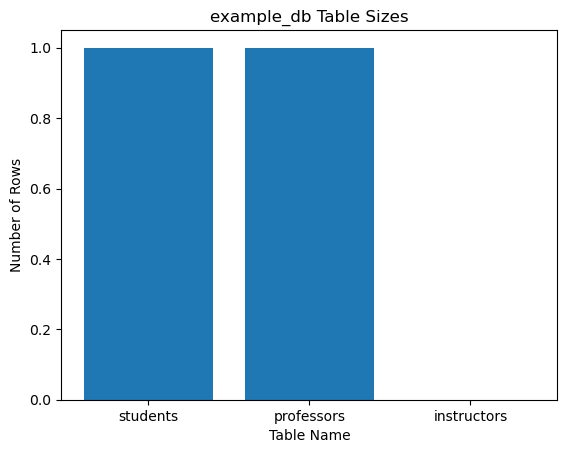

[{'name': 'Bob', 'age': 21, 'average_grade': 3.8}]


In [203]:

db = NoSQLDatabase("example_db")

# Создаем таблицу "students"
db.create_table("students")
db.create_table("professors")
db.create_table("instructors")

# Добавляем данные в таблицу "students"
db.insert_row("students", {"name": "Alice", "age": 22, "average_grade": 4.5})
db.insert_row("students", {"name": "Bob", "age": 21, "average_grade": 3.8})
db.insert_row("students", {"name": "Charlie", "age": 23, "average_grade": 4.2})


db.insert_row("professors", {"name": "Adnan", "age": 45, "education": "PhD"})

# Выбираем все строки из таблицы "students"
rows = db.select_rows("students")
print(rows)
# [{'name': 'Alice', 'age': 22, 'average_grade': 4.5}, {'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]

# Фильтруем строки в таблице "students" по возрасту
def filter_fn(row):
    return row["age"] > 21

filtered_rows = db.select_rows("students", filter_fn=filter_fn)
print(filtered_rows)
# [{'name': 'Alice', 'age': 22, 'average_grade': 4.5}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]

# Сортируем строки в таблице "students" по среднему баллу
def sort_fn(row):
    return row["average_grade"]

sorted_rows = db.select_rows("students", sort_fn=sort_fn)
print(sorted_rows)
# [{'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}, {'name': 'Alice', 'age': 22, 'average_grade': 4.5}]

# Обновляем средний балл для студента с именем "Alice"
def update_fn(row):
    if row["name"] == "Alice":
        row["average_grade"] = 4.8

db.update_rows("students", filter_fn=filter_fn, update_fn=update_fn)

updated_rows = db.select_rows("students")
print(updated_rows)
# [{'name': 'Alice', 'age': 22, 'average_grade': 4.8}, {'name': 'Bob', 'age': 21, 'average_grade': 3.8}, {'name': 'Charlie', 'age': 23, 'average_grade': 4.2}]
NoSQLDatabase.plot_table_data("example_db")
# Удаляем строки в таблице "students" по возрасту
db.delete_rows("students", filter_fn=filter_fn)

remaining_rows = db.select_rows("students")
NoSQLDatabase.plot_table_data("example_db")
print(remaining_rows)
# [{'name': 'Bob', 'age': 21, 'average_grade': 3.8}]


Database created!
{'id': 1, 'name': 'John Doe', 'age': 30, 'image_path': '/Users/itsu/incubator/2.png', 'type': 'image'}


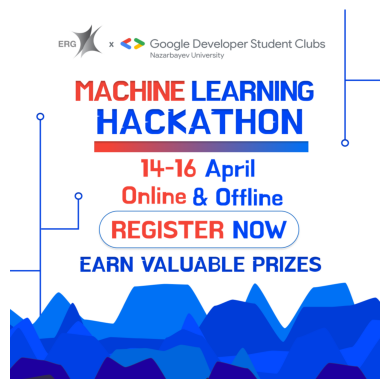

In [204]:
      
# Тест на сохранение фото
# Создаем базу данных и таблицу
my_db = NoSQLDatabase("mydbimage")
my_db.create_table("users")

# Добавляем пользователя с изображением
user = {
    "id": 1,
    "name": "John Doe",
    "age": 30,
    "image_path": "/Users/itsu/incubator/2.png",
    "type": "image"
}

with open("2.png", "rb") as f:
    user_image_data = f.read()
# print(user["id"])
my_db.insert_row("users", user)
my_db.save_data_file(user["image_path"], user_image_data)

# print(user["id"])
# # Извлекаем данные пользователя и его изображение
selected_users = my_db.select_rows("users", lambda u: u["id"] == 1)
selected_user = selected_users[0]

with open(selected_user["image_path"], "rb") as f:
    user_image_data = f.read()

print(selected_user)
image_table = my_db.get_table("users")
image_id = 1

# Retrieve the image data from the table
image_data =  my_db.select_rows("users", lambda u: u["id"] == 1)

# Display the image
my_db.display_image("users", 1)